In [7]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from utils.features import prepare_for_training
from utils.hypothesis import sigmoid
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
import warnings
warnings.filterwarnings('ignore')

In [15]:
class LogisticRegression:
    def __init__(self, data, labels, polynomial_degree=0, sinusoid_degree=0, normalize_data=True):
        """
        1、对数据进行预处理操作
        2、先得到所有的特征个数
        3、初始化参数矩阵
        """
        (data_processed,
         features_mean,
         features_deviation) = prepare_for_training(data, polynomial_degree, sinusoid_degree,normalize_data)
        
        self.data = data_processed
        self.labels = labels
        self.unique_labels = np.unique(labels)
        self.features_mean = features_mean
        self.features_deviation = features_deviation
        self.polynomial_degree = polynomial_degree
        self.sinusoid_degree = sinusoid_degree
        self.normalize_data = normalize_data
        
        num_features = self.data.shape[1]
        num_unique_labels = np.unique(labels).shape[0]
        self.theta = np.zeros((num_unique_labels,num_features))
    
    def train(self,num_iterations = 1000):
        cost_histories = []
        num_features = self.data.shape[1]
        for label_index, unique_label in enumerate(self.unique_labels):
            current_initial_theta = np.copy(self.theta[label_index].reshape(num_features, 1))
            current_labels = (self.labels == unique_label).astype(float)
            (current_theta, cost_history) = LogisticRegression.gradict_descent(self.data, current_labels, current_initial_theta,num_iterations)
            self.theta[label_index] = current_theta.T
            cost_histories.append(cost_history)
        return self.theta, cost_histories
            
    @staticmethod
    def gradict_descent(data, labels, current_initial_theta,max_iterations):
        cost_history = []
        num_features = data.shape[1]
        result = minimize(
            ## 优化目标
            lambda current_theta:LogisticRegression.cost_function(data, labels, current_theta.reshape(num_features, 1)),
            ## 初始化权重参数
            current_initial_theta,
            ## 选择优化策略
            method="CG",
            ## 梯度下降迭代计算公式
            jac=lambda current_theta:LogisticRegression.gradict_step(data, labels, current_theta.reshape(num_features, 1)),
            ## 记录结果
            callback=lambda current_theta:cost_history.append(LogisticRegression.cost_function(data, labels, current_theta.reshape(num_features, 1))),
            ## 迭代次数
            options={"maxiter":max_iterations}
        )
        if not result.success:
            raise ArithmeticError("Can not minimize cost function"+result.message)
        optimized_theta = result.x.reshape(num_features, 1)
        return optimized_theta, cost_history

    @staticmethod
    def cost_function(data, labels, theta):
        num_excamples = data.shape[0]
        predictions = LogisticRegression.hypothesis(data,theta)
        y_is_set_cost = np.dot(labels[labels == 1].T,np.log(predictions[labels == 1]))
        y_is_not_set_cost = np.dot(1 - labels[labels == 0].T,np.log(1 - predictions[labels == 0]))
        return (-1/ num_excamples) * (y_is_set_cost + y_is_not_set_cost)
        
    @staticmethod
    def hypothesis(data,theta):
        return sigmoid(np.dot(data, theta))
    
    @staticmethod
    def gradict_step(data, labels, theta):
        num_examples = labels.shape[0]
        predictions = LogisticRegression.hypothesis(data, theta)
        label_diff = predictions - labels
        return (1 / num_examples) * np.dot(data.T, label_diff).T.flatten()
    
    def predict(self,data):
        num_examples = data.shape[0]
        data_processed = prepare_for_training(data, self.polynomial_degree, self.sinusoid_degree, self.normalize_data)[0]
        prob = LogisticRegression.hypothesis(data_processed, self.theta.T)
        max_prob_index = np.argmax(prob, axis=1)
        class_prediction = np.empty(max_prob_index.shape, dtype=object)
        for index,label in enumerate(self.unique_labels):
            class_prediction[max_prob_index == index] = label
        return class_prediction.reshape((num_examples, 1))

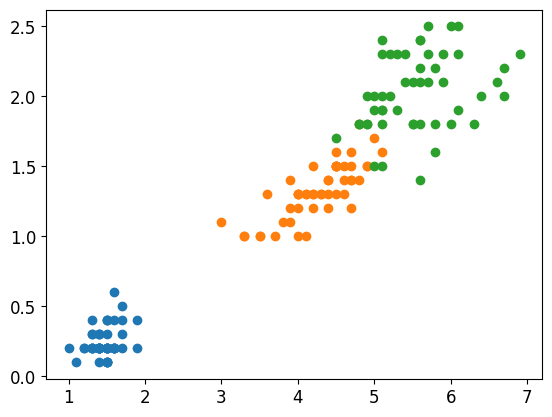

In [16]:
## 鸢尾花数据集
data= pd.read_csv("./data/iris.csv")
iris_types = ["SETOSA","VERSICOLOR","VIRGINICA"]
x_axis = "petal_length"
y_axis = "petal_width"

for iris_type in iris_types:
    plt.scatter(data[x_axis][data["class"] == iris_type],
                data[y_axis][data["class"] == iris_type],
                label= iris_type
                )
plt.show()

In [17]:
num_excamples = data.shape[0]
x_train = data[[x_axis, y_axis]].values.reshape((num_excamples, 2))
y_train = data["class"].values.reshape((num_excamples, 1))

max_iterations = 1000
polynomial_degree=0
sinusoid_degree=0

logisticRegression = LogisticRegression(x_train, y_train, polynomial_degree, sinusoid_degree)

thetas, cost_histories = logisticRegression.train(max_iterations)
labels = logisticRegression.unique_labels

plt.plot(
    range(len(cost_histories[0])),
    cost_histories[0],
    labels = labels[0]
)

plt.plot(
    range(len(cost_histories[1])),
    cost_histories[1],
    labels = labels[1]
)

plt.plot(
    range(len(cost_histories[2])),
    cost_histories[2],
    labels = labels[2]
)

plt.show()

ValueError: 'x0' must only have one dimension.